In [1]:
%matplotlib inline

import boutdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import xhermes
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# Overview

### I tuned fast recycling and went to MFP 0.1 with separate limiters and conduction limitation

# Hermes IO

In [102]:
casestore = dict()

In [103]:
   
db = CaseDB()
toload = [
	dict(name="afnE_1e19", id = "d26b-c0.25_f0.48_1e19"),
	# dict(name="afnE_3e19", id = "d26c-c0.25_f0.48_3e19"),
	dict(name="afnE_2e19_fixnbc", id = "d34-d28a_neutbc_fixes"),
	# dict(name="afn_new_cond0.1", id = "d21a-cond_alpha_0.1")
]
casestore = {}
for case in toload:
	casestore[case["name"]] = db.load_case_2D(case["id"], use_squash = True, verbose = True, use_xhermes = False)

- Reading case d26b-c0.25_f0.48_1e19
-----------------------
- Looking for squash file
- Squash file found. squash date 12/05/2023, 14:40:59, dmp file date 10/20/2023, 15:27:39

- Reading case d34-d28a_neutbc_fixes
-----------------------
- Looking for squash file
- Squash file found. squash date 12/12/2023, 11:28:35, dmp file date 12/11/2023, 19:20:57



In [104]:
path = r"C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3b2-fatter_newhypno.nc"

with nc.Dataset(path) as d:
	print(d.variables.keys())
	psixy = d["psixy"][:]
 
psixy = np.expand_dims(psixy, axis = 2)

dict_keys(['nx', 'ny', 'y_boundary_guards', 'curvature_type', 'Bt_axis', 'psi_axis', 'psi_bdry', 'psi_axis_gfile', 'psi_bdry_gfile', 'Rxy', 'Rxy_xlow', 'Rxy_ylow', 'Zxy', 'Zxy_xlow', 'Zxy_ylow', 'psixy', 'psixy_xlow', 'psixy_ylow', 'dx', 'dx_xlow', 'dx_ylow', 'dy', 'dy_xlow', 'dy_ylow', 'poloidal_distance', 'poloidal_distance_xlow', 'poloidal_distance_ylow', 'Brxy', 'Brxy_xlow', 'Brxy_ylow', 'Bzxy', 'Bzxy_xlow', 'Bzxy_ylow', 'Bpxy', 'Bpxy_xlow', 'Bpxy_ylow', 'Btxy', 'Btxy_xlow', 'Btxy_ylow', 'Bxy', 'Bxy_xlow', 'Bxy_ylow', 'hy', 'hy_xlow', 'hy_ylow', 'dphidy', 'dphidy_xlow', 'dphidy_ylow', 'ShiftTorsion', 'ShiftTorsion_xlow', 'ShiftTorsion_ylow', 'zShift', 'zShift_xlow', 'zShift_ylow', 'g11', 'g11_xlow', 'g11_ylow', 'g22', 'g22_xlow', 'g22_ylow', 'g33', 'g33_xlow', 'g33_ylow', 'g12', 'g12_xlow', 'g12_ylow', 'g13', 'g13_xlow', 'g13_ylow', 'g23', 'g23_xlow', 'g23_ylow', 'J', 'J_xlow', 'J_ylow', 'g_11', 'g_11_xlow', 'g_11_ylow', 'g_22', 'g_22_xlow', 'g_22_ylow', 'g_33', 'g_33_xlow', 'g_33_

In [105]:
plt.close("all")
%matplotlib inline

# SOLPS io

In [3]:
solpscases = {
	"noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
	"tightwall_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19",
	"tightwall_noD2_1e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2",
	"tightwall_noD2_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2",
	"tightwall_noD2_3e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2",
	
}



In [6]:
casechoice = "tightwall_noD2_2e19"
spc = self = SOLPScase(solpscases[casechoice])
g = read_b2fgmtry(where = solpscases[casechoice], save = False, ghost_cells = True, force = True)


b2fgmtry loaded from .pkl
read_b2fgmtry -- file version 03.000.007
110 36


In [7]:
g["crx"].shape

(112, 38, 4)

# Establish regions on Hermes-3 side

In [6]:
ds = casestore["afnE_2e19_fixnbc"].ds.isel(t=-1)

## Field aligned grid

In [55]:
x = psixy
y = ds["theta_idx"].values
y = np.expand_dims(y, axis = 0)
y = np.expand_dims(y, axis = 2)
y = np.repeat(y, x.shape[0], axis = 0)

print(x.shape)
print(y.shape)

(40, 108, 1)
(40, 108, 1)


In [60]:
print(x.shape)
print(y.shape)

(40, 108)
(40, 108)


C:\Users\mikek\AppData\Local\Temp\ipykernel_38980\2245445219.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axes[1].pcolormesh(x_region, y_region, np.ones_like(x_region),
C:\Users\mikek\AppData\Local\Temp\ipykernel_38980\2245445219.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axes[1].pcolormesh(x_region, y_region, np.ones_like(x_region),
C:\Users\mikek\AppData\Local\Temp\ipykernel_38980\2245445219.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly cal

Text(0.5, 1.0, 'Flux space grid')

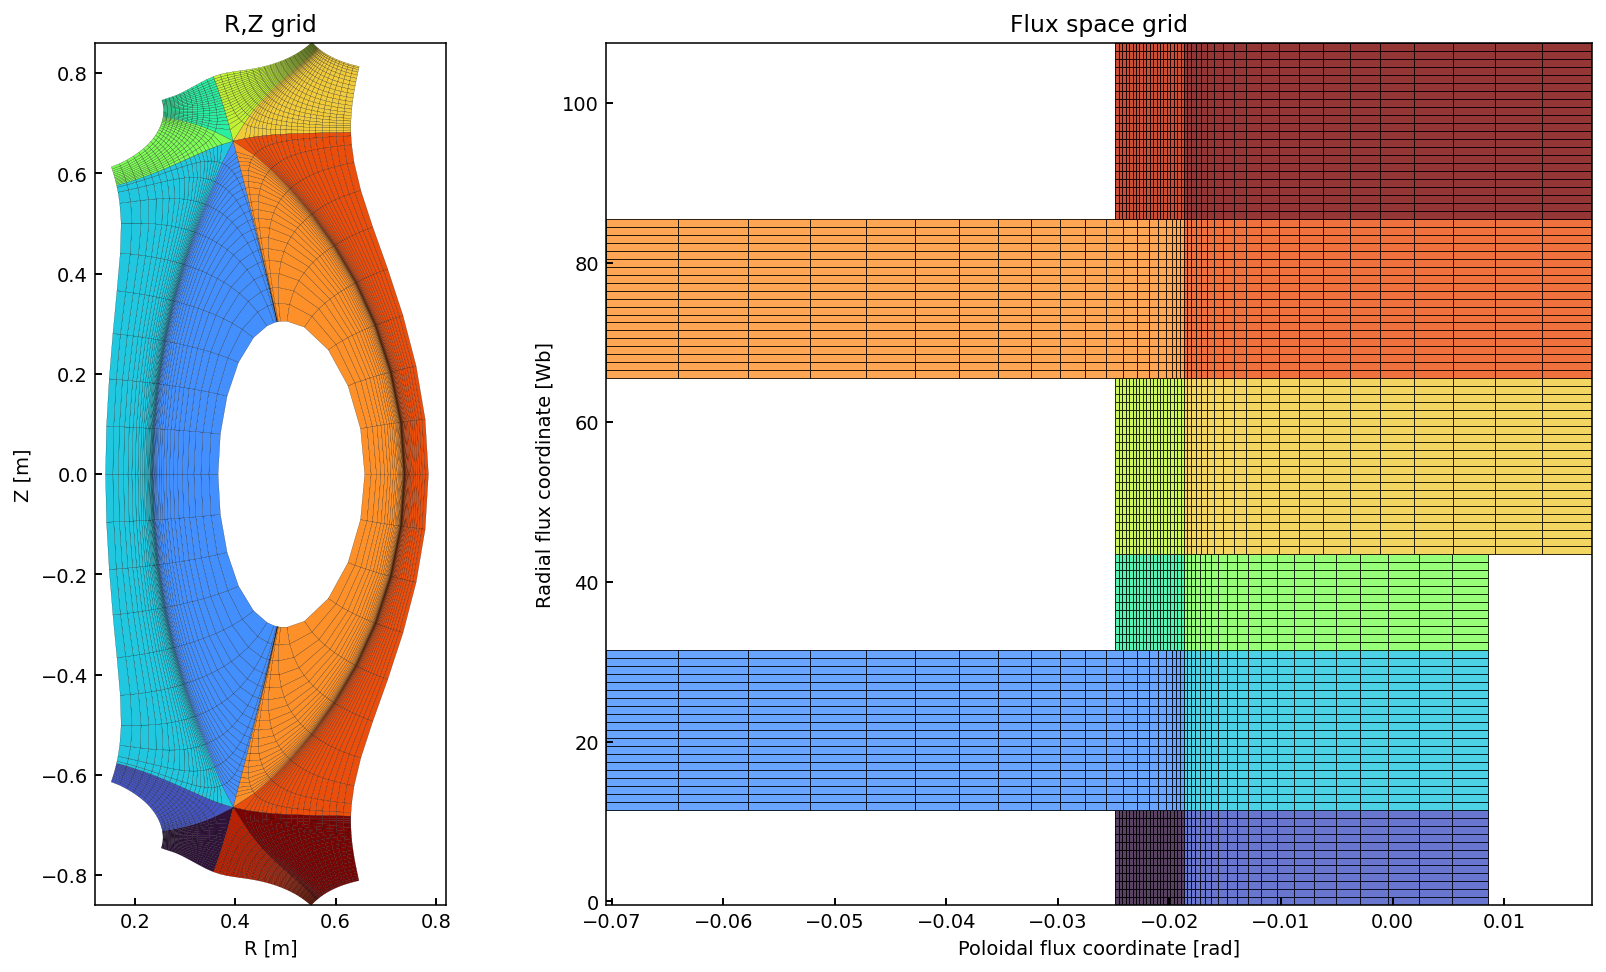

In [62]:
plt.close("all")
colors = mpl.colormaps["turbo"](np.linspace(0, 1, len(ds.regions.keys())))
regions = ds.regions.keys()
fig, axes = plt.subplots(1,2, dpi = 140, figsize = (14,8), width_ratios = (0.4, 1))
# x = np.cumsum(ds["dx"], axis = 0)

x = psixy
y = ds["theta_idx"].values
y = np.expand_dims(y, axis = 0)
y = np.expand_dims(y, axis = 2)
y = np.repeat(y, x.shape[0], axis = 0)

x = x.squeeze()
y = y.squeeze()
# y = np.cumsum(ds["dy"], axis = 1)

for i, region in enumerate(regions):
	
	reg = ds[ds.regions[region].get_slices()]
 
	reg["Ne"].bout.polygon(
		ax = axes[0],
		separatrix = False, targets = False, 
		cmap = mpl.colors.ListedColormap([colors[i]]), 
		antialias = True,
		add_colorbar = False,
		linewidth = 0.1)
	
	slices = ds.regions[region].get_slices()
	
	# slices = dict(x = slices["x"][:,:,0], y = slices["thetas"][:,:,0])
	x_region = x[slices["x"], slices["theta"]]
	y_region = y[slices["x"], slices["theta"]]

	axes[1].pcolormesh(x_region, y_region, np.ones_like(x_region), 
				
				cmap = mpl.colors.ListedColormap([colors[i]]),
				rasterized = True,
				edgecolor = "black",
				linewidth = 0.5,
				alpha = 0.8,
				shading = "nearest")
	
axes[0].autoscale()
axes[0].set_xlim(0.12, 0.82)
axes[0].set_ylim(-0.86, 0.86)
for ax in axes:
	ax.grid(visible = False)
axes[1].set_xlabel("Psi")
axes[1].set_ylabel("Poloidal index")
axes[0].set_title("R,Z grid")
axes[1].set_title("Flux space grid")

# SOLPS

## Get poloidal mesh

In [119]:
print(g["nx"], g["ny"])
spc.g["R"].shape

110 36


(112, 38)

In [131]:
%matplotlib widget


In [135]:
g["resignore"].shape

(110, 36, 2)

(110, 36)
(112, 38)


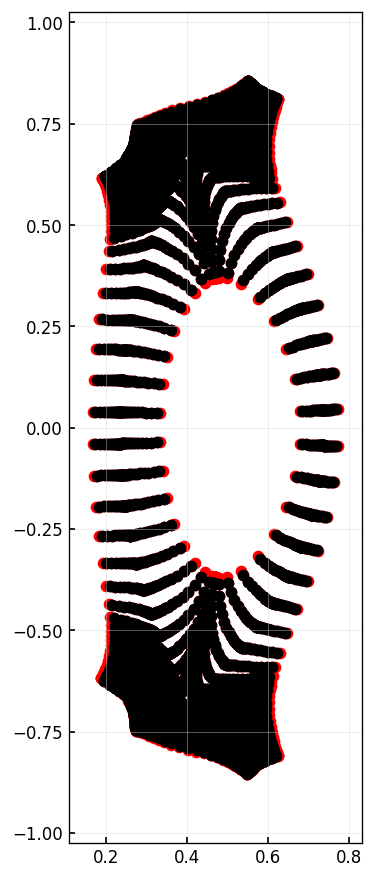

In [132]:
plt.close("all")
Ra = np.mean(g["crx"], axis = 2)
Rb = np.mean(spc.g["crx"], axis = 2)

Za = np.mean(g["cry"], axis = 2)
Zb = np.mean(spc.g["cry"], axis = 2)

fig, ax =plt.subplots(figsize = (15,9))


print(Ra.shape)
print(Rb.shape)

ax.scatter(Rb, Zb, c = "r")
ax.scatter(Ra, Za, c = "k")
ax.set_aspect("equal")




In [114]:
g["resignore"].shape

(110, 36, 2)

In [108]:
leftcut = g["leftcut"].astype(np.int64)
rightcut = g["rightcut"].astype(np.int64)
topcut = g["topcut"].astype(np.int64)
# sep = spc.g["sep"]
sep = topcut[1]
upper_break = spc.g["upper_break"].astype(np.int64)

for x in [leftcut, rightcut, topcut, sep, upper_break]:
	print(x)

[11 35]
[91 67]
[17 17]
17
50


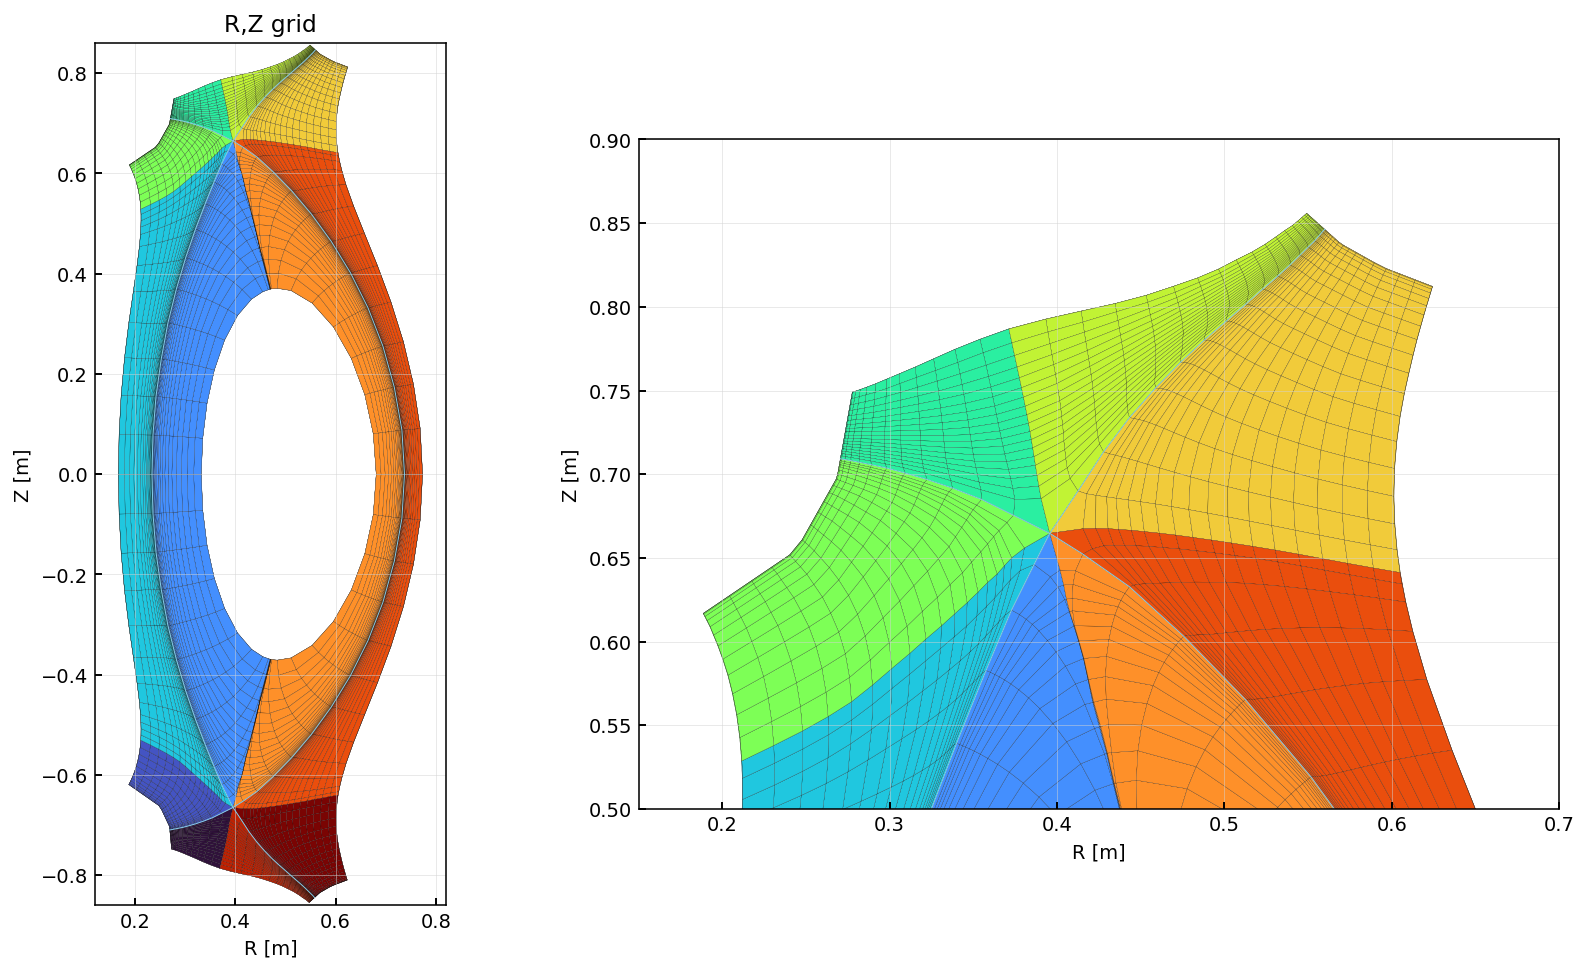

In [161]:



region_sel = {}
region_sel["lower_inner_pfr"] = (slice(None, leftcut[0]+2), slice(None, sep+2))
region_sel["lower_inner_SOL"] = (slice(None, leftcut[0]+2), slice(sep+2, None))
region_sel["inner_core"] = (slice(leftcut[0]+2, leftcut[1]+2), slice(None, sep+2))
region_sel["inner_SOL"] = (slice(leftcut[0]+2, leftcut[1]+2), slice(sep+2, None))
region_sel["upper_inner_PFR"] = (slice(leftcut[1]+2, upper_break), slice(None, sep+2))
region_sel["upper_inner_SOL"] = (slice(leftcut[1]+2, upper_break), slice(sep+2, None))
region_sel["upper_outer_PFR"] = (slice(upper_break, rightcut[1]+2), slice(None, sep+2))
region_sel["upper_outer_SOL"] = (slice(upper_break, rightcut[1]+2), slice(sep+2, None))
region_sel["outer_core"] = (slice(rightcut[1]+2, rightcut[0]+2), slice(None, sep+2))
region_sel["outer_SOL"] = (slice(rightcut[1]+2, rightcut[0]+2), slice(sep+2, None))
region_sel["lower_outer_PFR"] = (slice(rightcut[0]+2, None), slice(None, sep+2))
region_sel["lower_outer_SOL"] = (slice(rightcut[0]+2, None), slice(sep+2, None))

data = self.bal["ne"][:]
data = np.zeros_like(data)

# data[region_sel["lower_inner_pfr"]] = 1
# data[region_sel["lower_inner_SOL"]] = 2

for i, key in enumerate(region_sel):
	i += 1
	# if list(region_sel.keys())[-1] in key:
	#         data[region_sel[key]] = i
			
	data[region_sel[key]] = i

colors = mpl.colormaps["turbo"](np.linspace(0, 1, len(ds.regions.keys())))

fig, axes = plt.subplots(1,2, figsize = (14,8), dpi = 140, width_ratios=(0.5,1))
for i, ax in enumerate(axes):
	self.plot_2d("", ax = axes[i], data = data, cmap = mpl.colors.ListedColormap(["white"] + list(colors)),
		antialias = True, 
		cbar = False,
		vmin = 0, vmax = 12,
		linecolor = "black", linewidth = 0.1,
		separatrix_kwargs = dict(lw = 0.5, c = "skyblue"))

axes[0].set_xlim(0.12, 0.82)
axes[0].set_ylim(-0.86, 0.86)
axes[0].set_title("R,Z grid")
		
def zoomView(ax, region):
	lims = dict(
		lower_inner = dict(
				xlim = (0.15, 0.4),
				ylim = (-0.81, -0.5)
		),
		upper = dict(
				xlim = (0.15, 0.7),
				ylim = (0.5, 0.9)
		)
	)
	
	if region in lims.keys():
		ax.set_xlim(lims[region]["xlim"])
		ax.set_ylim(lims[region]["ylim"])
	else:
		raise Exception(f"Region {region} not found")
				
		
zoomView(axes[1], "upper")
		
# spc.plot_selection(sel)

## Attempt logical grid

In [74]:
x = g["fpsi"].mean(axis = 2)  # Mean over all four cell corners
print(x.shape)
y = np.array(range(x.shape[0]))
y = np.expand_dims(y, axis = 1)
y = np.repeat(y, x.shape[1], axis = 1)
print(y.shape)

(110, 36)
(110, 36)


C:\Users\mikek\AppData\Local\Temp\ipykernel_38980\1666124421.py:72: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axes[1].pcolormesh(region_x, region_y, np.ones((region_x.shape)),


Text(0, 0.5, 'Poloidal cell index')

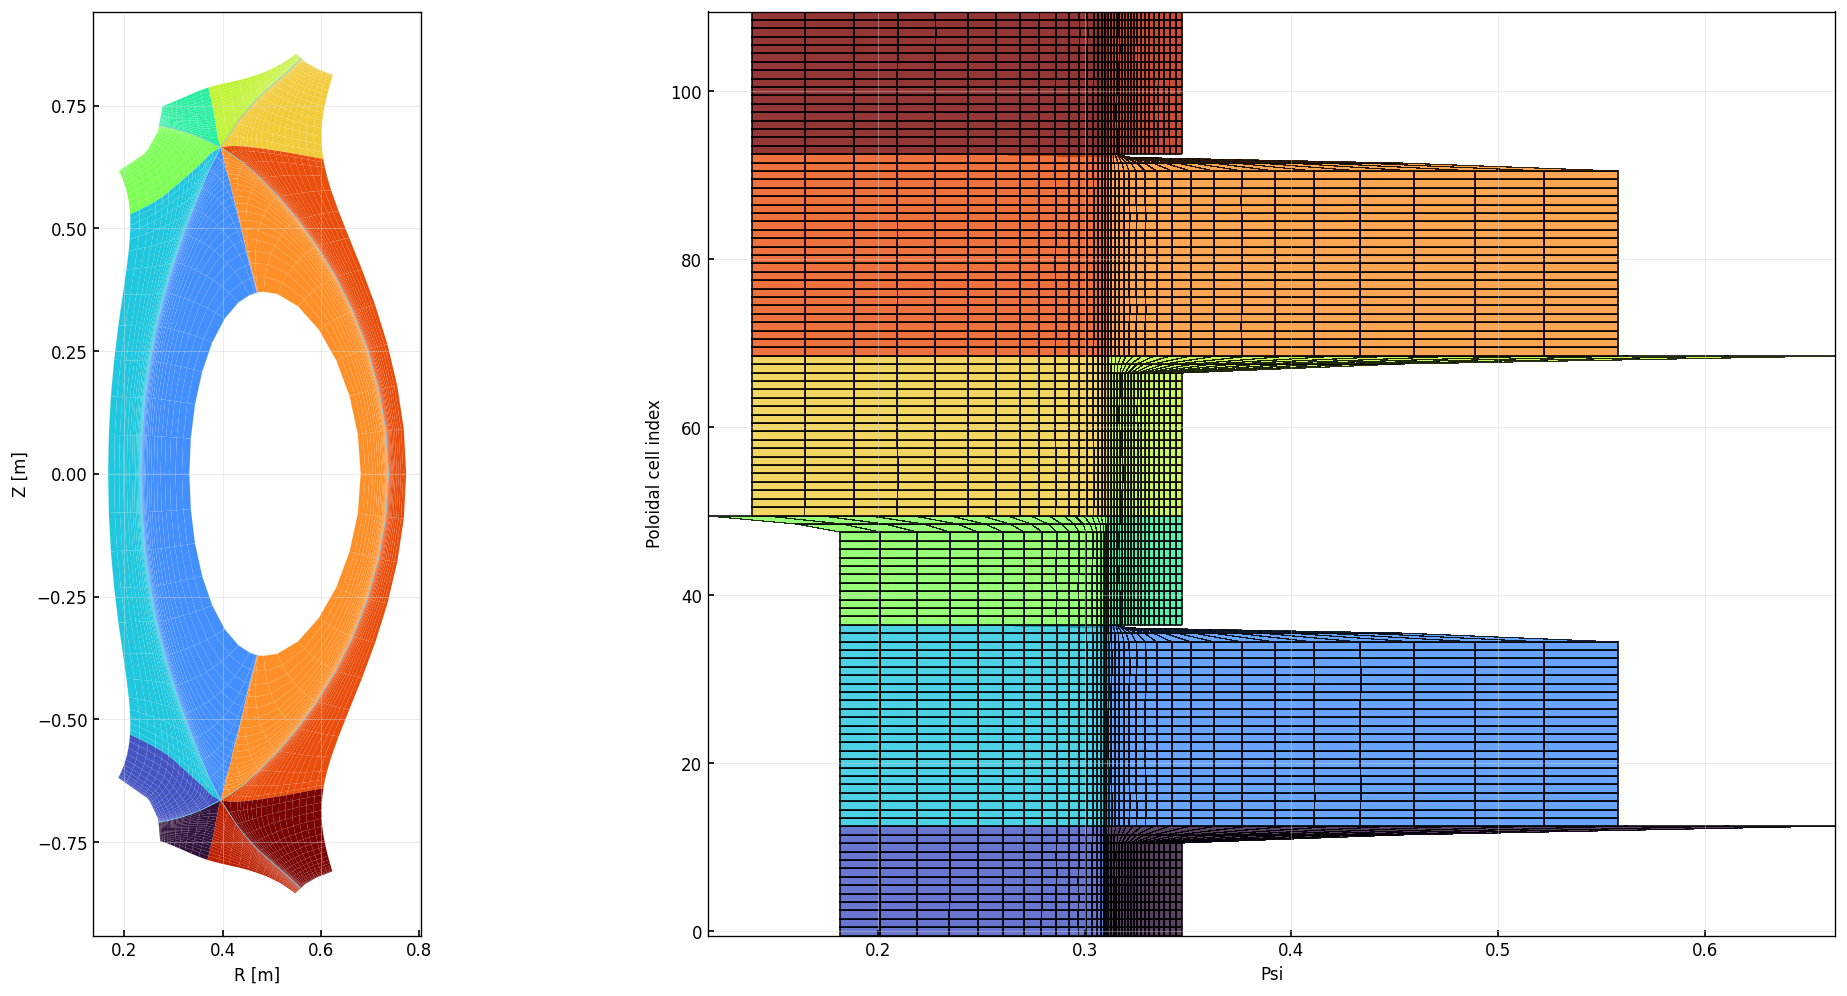

In [81]:
plt.close("all")

leftcut = g["leftcut"]
rightcut = g["rightcut"]
topcut = g["topcut"]
# sep = spc.g["sep"]
sep = topcut[1]
upper_break = spc.g["upper_break"]


region_sel = {}
region_sel["lower_inner_PFR"] = (slice(None, leftcut[0]+2), slice(None, sep+2))
region_sel["lower_inner_SOL"] = (slice(None, leftcut[0]+2), slice(sep+2, None))
region_sel["inner_core"] = (slice(leftcut[0]+2, leftcut[1]+2), slice(None, sep+2))
region_sel["inner_SOL"] = (slice(leftcut[0]+2, leftcut[1]+2), slice(sep+2, None))
region_sel["upper_inner_PFR"] = (slice(leftcut[1]+2, upper_break), slice(None, sep+2))
region_sel["upper_inner_SOL"] = (slice(leftcut[1]+2, upper_break), slice(sep+2, None))
region_sel["upper_outer_PFR"] = (slice(upper_break, rightcut[1]+2), slice(None, sep+2))
region_sel["upper_outer_SOL"] = (slice(upper_break, rightcut[1]+2), slice(sep+2, None))
region_sel["outer_core"] = (slice(rightcut[1]+2, rightcut[0]+2), slice(None, sep+2))
region_sel["outer_SOL"] = (slice(rightcut[1]+2, rightcut[0]+2), slice(sep+2, None))
region_sel["lower_outer_PFR"] = (slice(rightcut[0]+2, None), slice(None, sep+2))
region_sel["lower_outer_SOL"] = (slice(rightcut[0]+2, None), slice(sep+2, None))

data = self.bal["ne"][:]
data = np.zeros_like(data)

# data[region_sel["lower_inner_pfr"]] = 1
# data[region_sel["lower_inner_SOL"]] = 2

for i, key in enumerate(region_sel):
	i += 1
	# if list(region_sel.keys())[-1] in key:
	#         data[region_sel[key]] = i
			
	data[region_sel[key]] = i

colors = mpl.colormaps["turbo"](np.linspace(0, 1, len(ds.regions.keys())))
scale =  2
fig, axes = plt.subplots(1,2, figsize = (10* scale,5* scale), width_ratios=(0.5,1))


self.plot_2d("", ax = axes[0], data = data, cmap = mpl.colors.ListedColormap(["white"] + list(colors)),
	antialias = True, 
	cbar = False,
	vmin = 0, vmax = 12,
	separatrix_kwargs = dict(lw = 0.5, c = "skyblue"))
 


x = g["fpsi"].mean(axis = 2)  # Mean over all four cell corners
y = np.array(range(x.shape[0]))
y = np.expand_dims(y, axis = 1)
y = np.repeat(y, x.shape[1], axis = 1)

for i, key in enumerate(region_sel):
	# if list(region_sel.keys())[-1] in key:
	#         data[region_sel[key]] = i
	"""
	Remember that SOLPS nomenclature is opposite: X is poloidal, Y is radial
 
	# """
	# hx = np.cumsum(spc.g["hx"], axis = 0)         # POLOIDAL
	# hy = np.cumsum(spc.g["hy"], axis = 1)        # RADIAL 
 
	# x = hy[region_sel[key]]
	# y = hx[region_sel[key]]
 
	region_x = x[region_sel[key]]
	region_y = y[region_sel[key]]

	axes[1].pcolormesh(region_x, region_y, np.ones((region_x.shape)), 
				
				cmap = mpl.colors.ListedColormap([colors[i]]),
				rasterized = True,
				edgecolor = "k",
				linewidth = 0.1,
				alpha = 0.8,
				shading = "nearest")
		
axes[1].set_xlabel("Psi")
axes[1].set_ylabel("Poloidal cell index")

# Hermes-3 and SOLPS on a region basis

## drad /dl basis
- This doesn't work because you need h_theta to reproduce dl (poloidal length)
- h_theta is kind of like an angle - it's something which unwraps the case poloidally
- The closest replacement for this is the cell index, but that's not so easy because you have to adjust it to map it from SOLPS to Hermes-3
- Keeping the below for refernce but it doesnt work


C:\Users\mikek\AppData\Local\Temp\ipykernel_52844\1221845868.py:49: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axes[0,0].pcolormesh(reg["R"], reg["Z"], c_h, **stylekwargs)
C:\Users\mikek\AppData\Local\Temp\ipykernel_52844\1221845868.py:53: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axes[0,1].pcolormesh(R_s, Z_s, c_s, **stylekwargs)


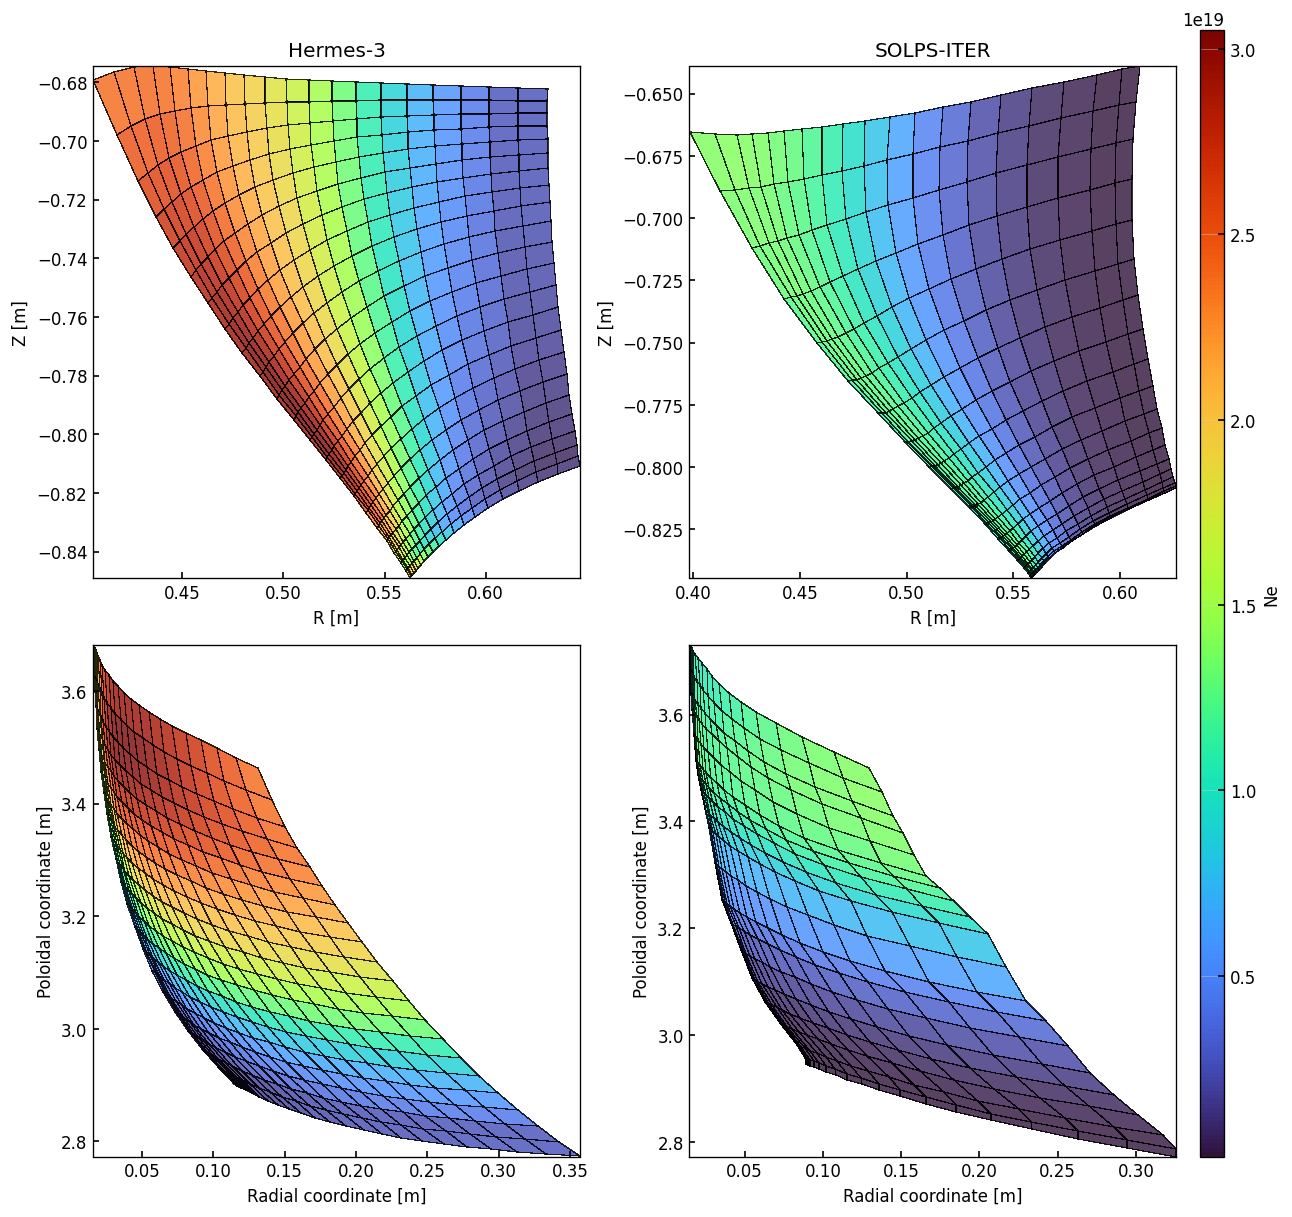

In [147]:
plt.close("all")

# region = "lower_inner_PFR"
# for region in regions:
for region in ["lower_outer_SOL"]:
	color = colors[list(regions).index(region)]
	cmap = mpl.colors.ListedColormap([color])
	cmap = "turbo"
	logscale = False


	## Data prep
	# Hermes-3
	reg = ds[ds.regions[region].get_slices()]
	# pol_h = np.cumsum(reg["dl"], axis = 1)
	# rad_h = np.cumsum(reg["dr"], axis = 0)
 
	pol_h = np.cumsum(ds["dl"], axis = 1)[ds.regions[region].get_slices()]
	rad_h = np.cumsum(ds["dr"], axis = 0)[ds.regions[region].get_slices()]
	c_h = reg["Ne"].values

	# SOLPS-ITER
	hx = np.cumsum(spc.g["hx"], axis = 0)         # POLOIDAL
	hy = np.cumsum(spc.g["hy"], axis = 1)        # RADIAL 
	pol_s = hx[region_sel[region]]
	rad_s = hy[region_sel[region]]
	R_s = spc.g["R"][region_sel[region]]
	Z_s = spc.g["Z"][region_sel[region]]
	c_s = spc.bal["ne"][:][region_sel[region]]

	## Plots
	fig, axes = plt.subplots(2,2, figsize = (10,10))

	vmin = np.min([np.min(c_h), np.min(c_s)])
	vmax = np.max([np.max(c_h), np.max(c_s)])
	norm = create_norm(logscale, None, vmin, vmax)
	
	stylekwargs = dict(cmap = cmap,
				rasterized = True,
				edgecolor = "k",
				linewidth = 0.1,
				alpha = 0.8,
				shading = "nearest",
				norm = norm
				)

	# Hermes-3
	axes[1,0].pcolormesh(rad_h, pol_h, c_h, **stylekwargs)
	axes[0,0].pcolormesh(reg["R"], reg["Z"], c_h, **stylekwargs)

	# SOLPS-ITER
	axes[1,1].pcolormesh(rad_s, pol_s, c_s, **stylekwargs)
	axes[0,1].pcolormesh(R_s, Z_s, c_s, **stylekwargs)

	## Formatting
	for ax in axes.flatten():
		ax.grid(False)
		
	for ax in axes[0,:].flatten():
		ax.set_xlabel("R [m]")
		ax.set_ylabel("Z [m]")
	
	for ax in axes[1,:].flatten():
		ax.set_xlabel("Radial coordinate [m]")
		ax.set_ylabel("Poloidal coordinate [m]")
	
	axes[0,0].set_title("Hermes-3")
	axes[0,1].set_title("SOLPS-ITER")

	sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
	fig.tight_layout()
	cax = fig.add_axes([
		axes[0,1].get_position().x1+0.02,
		axes[1,1].get_position().y0,
		0.02,
		axes[1,1].get_position().height * 2.2
	])

	cbar = plt.colorbar(mappable = sm, cax=cax, label = "Ne") # Similar to fig.colorbar(im, cax = cax)


## Using psi and poloidal index mapping
- Need to unwrap the grid to show it in a way that takes the field out and makes it rectangular
- Psi does that for the radial direction
- In the poloidal in BOUT++ we have h_theta, which is kind of like a poloidal angle but it cannot be calculated from first principles
- The closest replacement is the poloidal cell index
- We can do this on a per region basis and normalise the poloidal cell index from 0 to 1. Unfortunately this probably won't work very well unless the mapping is manually adjusted to account for non-orthogonal cells etc

In [90]:
print(pol_s.shape)
print(rad_s.shape)
print(c_s.shape)

(17, 17)
(17, 17)
(19, 19)


In [93]:
spc.bal["ne"][:].shape

(112, 38)

In [97]:
spc.bal["ne"][:].shape

(112, 38)

In [95]:
g["crx"].shape

(110, 36, 4)

In [100]:
spc.bal["crx"][:,2]

masked_array(
  data=[[0.2726194 , 0.27262464, 0.27229876, 0.27230408],
        [0.27262464, 0.27314781, 0.27230408, 0.2728355 ],
        [0.27314781, 0.27477963, 0.2728355 , 0.27449317],
        [0.27477963, 0.27761974, 0.27449317, 0.27738335],
        [0.27761974, 0.28174294, 0.27738335, 0.28158706],
        [0.28174294, 0.28727446, 0.28158706, 0.28722943],
        [0.28727446, 0.29427782, 0.28722943, 0.29436451],
        [0.29427782, 0.30264597, 0.29436451, 0.30307599],
        [0.30264597, 0.31265851, 0.30307599, 0.31349201],
        [0.31265851, 0.32446346, 0.31349201, 0.32562847],
        [0.32446346, 0.33820288, 0.32562847, 0.33972109],
        [0.33820288, 0.35375621, 0.33972109, 0.35568826],
        [0.35375621, 0.37134619, 0.35568826, 0.37317029],
        [0.4628125 , 0.46245836, 0.45576462, 0.45545192],
        [0.46245836, 0.46207208, 0.45545192, 0.4550947 ],
        [0.46207208, 0.46163128, 0.4550947 , 0.45443607],
        [0.46163128, 0.4556002 , 0.45443607, 0.44507329],


In [94]:
g["hx"].shape

(110, 36)

In [91]:
g["fpsi"].shape

(110, 36, 4)

C:\Users\mikek\AppData\Local\Temp\ipykernel_38980\246398681.py:66: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axes[1,0].pcolormesh(rad_h, pol_h, c_h, **stylekwargs)
C:\Users\mikek\AppData\Local\Temp\ipykernel_38980\246398681.py:67: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axes[0,0].pcolormesh(reg["R"], reg["Z"], c_h, **stylekwargs)


TypeError: Dimensions of C (19, 19) are incompatible with X (17) and/or Y (17); see help(pcolormesh)

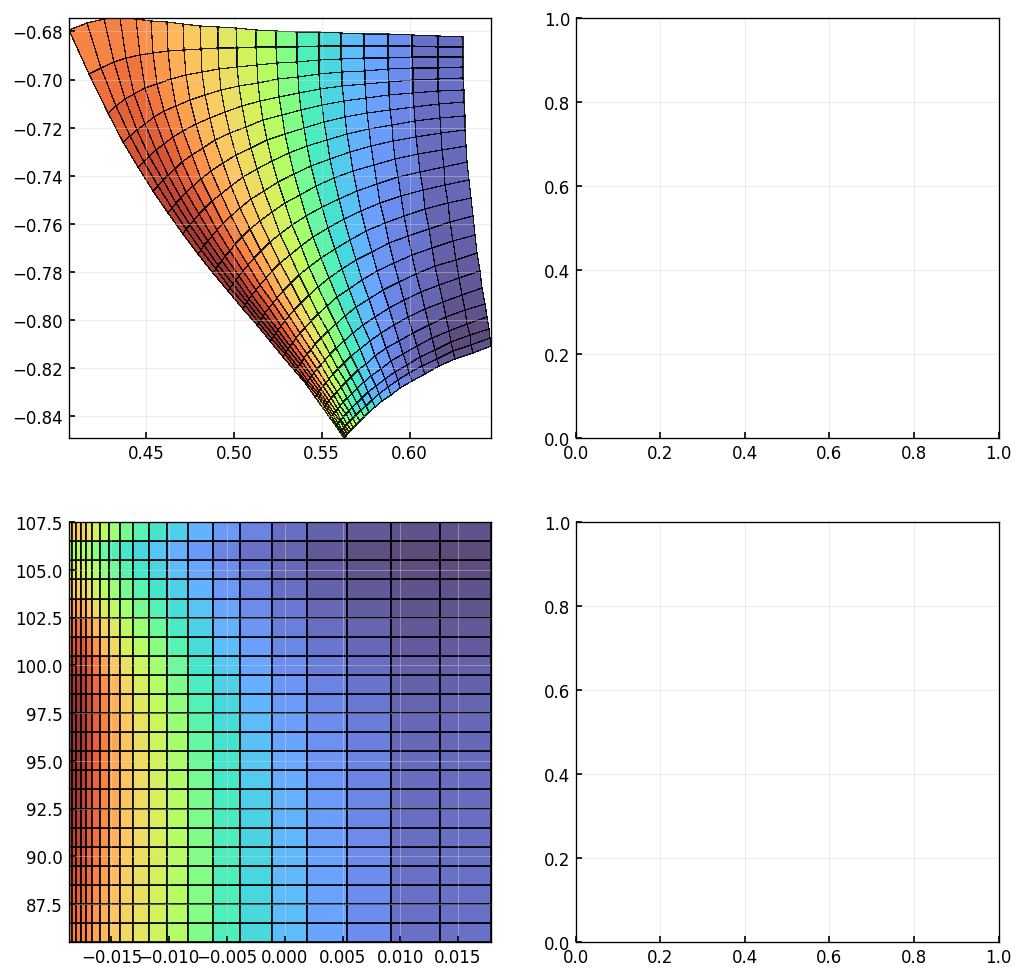

In [88]:
plt.close("all")

# region = "lower_inner_PFR"
# for region in regions:
for region in ["lower_outer_SOL"]:
	color = colors[list(regions).index(region)]
	cmap = mpl.colors.ListedColormap([color])
	cmap = "turbo"
	logscale = False


	## Data prep
	# Hermes-3
	# reg = ds[ds.regions[region].get_slices()]
	# pol_h = np.cumsum(reg["dl"], axis = 1)
	# rad_h = np.cumsum(reg["dr"], axis = 0)
 
	# pol_h = np.cumsum(ds["dl"], axis = 1)[ds.regions[region].get_slices()]
	# rad_h = np.cumsum(ds["dr"], axis = 0)[ds.regions[region].get_slices()]
 
	rad_h = psixy
	pol_h = ds["theta_idx"].values
	pol_h = np.expand_dims(pol_h, axis = 0)
	pol_h = np.expand_dims(pol_h, axis = 2)
	pol_h = np.repeat(pol_h, rad_h.shape[0], axis = 0)

	rad_h = rad_h.squeeze()
	pol_h = pol_h.squeeze()
 
	slices = ds.regions[region].get_slices()
 
	rad_h = rad_h[slices["x"], slices["theta"]]
	pol_h = pol_h[slices["x"], slices["theta"]]
	c_h = ds["Ne"][slices]

	# SOLPS-ITER
	rad_s = g["fpsi"].mean(axis = 2)  # Mean over all four cell corners
	pol_s = np.array(range(rad_s.shape[0]))
	pol_s = np.expand_dims(pol_s, axis = 1)
	pol_s = np.repeat(pol_s, rad_s.shape[1], axis = 1)
 
	rad_s = rad_s[region_sel[region]]
	pol_s = pol_s[region_sel[region]]

	R_s = spc.g["R"][region_sel[region]]
	Z_s = spc.g["Z"][region_sel[region]]
	c_s = spc.bal["ne"][:][region_sel[region]]

	## Plots
	fig, axes = plt.subplots(2,2, figsize = (10,10))

	vmin = np.min([np.min(c_h), np.min(c_s)])
	vmax = np.max([np.max(c_h), np.max(c_s)])
	norm = create_norm(logscale, None, vmin, vmax)
	
	stylekwargs = dict(cmap = cmap,
				rasterized = True,
				edgecolor = "k",
				linewidth = 0.1,
				alpha = 0.8,
				shading = "nearest",
				norm = norm
				)

	# Hermes-3
	axes[1,0].pcolormesh(rad_h, pol_h, c_h, **stylekwargs)
	axes[0,0].pcolormesh(reg["R"], reg["Z"], c_h, **stylekwargs)

	# SOLPS-ITER
	axes[1,1].pcolormesh(rad_s, pol_s, c_s, **stylekwargs)
	axes[0,1].pcolormesh(R_s, Z_s, c_s, **stylekwargs)

	## Formatting
	for ax in axes.flatten():
		ax.grid(False)
		
	for ax in axes[0,:].flatten():
		ax.set_xlabel("R [m]")
		ax.set_ylabel("Z [m]")
	
	for ax in axes[1,:].flatten():
		ax.set_xlabel("Radial coordinate [m]")
		ax.set_ylabel("Poloidal coordinate [m]")
	
	axes[0,0].set_title("Hermes-3")
	axes[0,1].set_title("SOLPS-ITER")

	sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
	fig.tight_layout()
	cax = fig.add_axes([
		axes[0,1].get_position().x1+0.02,
		axes[1,1].get_position().y0,
		0.02,
		axes[1,1].get_position().height * 2.2
	])

	cbar = plt.colorbar(mappable = sm, cax=cax, label = "Ne") # Similar to fig.colorbar(im, cax = cax)
